# DBSCAN Clustering
---

## 1. Introduction

Density-Based Spatial Clustering of Applications with Noise (DBSCAN) is an
unsupervised clustering algorithm that groups data points based on **local density**
rather than distance to a centroid.

Unlike K-Means, DBSCAN:

- Does not require specifying the number of clusters  
- Can discover arbitrarily shaped clusters  
- Explicitly identifies noise / outliers  
- Is robust to non-spherical cluster structure  

In this notebook, we apply DBSCAN using a **from-scratch implementation**
from the `rice_ml` package.

---

## 2. Mathematical Intuition Behind DBSCAN

DBSCAN relies on two hyperparameters:

- **$\varepsilon$ (epsilon)**: neighborhood radius  
- **`min_samples`**: minimum number of points required to form a dense region  

### $\varepsilon$-Neighborhood

For a point $x$, the $\varepsilon$-neighborhood is defined as:

$$
N_\varepsilon(x) = \{ y \mid \text{distance}(x, y) \le \varepsilon \}
$$

### Core Point

A point $x$ is a **core point** if:

$$
|N_\varepsilon(x)| \ge \text{min\_samples}
$$

### Border and Noise Points

- **Border point**: within $\varepsilon$ of a core point, but not dense itself  
- **Noise point**: not reachable from any core point  

Clusters are formed by **density reachability**: starting from a core point,
all reachable points are recursively added to the same cluster.

## Two Moons (Cluster Moons) Dataset

The Two Moons dataset is a synthetic benchmark dataset commonly used to
evaluate clustering algorithms on **non-linear and non-spherical structures**.

Each observation corresponds to a point in two-dimensional space. The data
forms two interleaving crescent-shaped clusters (“moons”), which violate the
assumptions of centroid-based clustering methods.

### Dataset Characteristics

- Designed to test non-linear clustering behavior
- Clusters are non-spherical and interleaved
- No centroid structure
- Well-suited for density-based methods such as DBSCAN

### Features

| Feature | Description |
|-------|-------------|
| x1 | First spatial coordinate |
| x2 | Second spatial coordinate |

All features are continuous and numeric.

### Structure

- Total samples: varies (commonly 200–500)
- Dimensionality: 2
- Cluster geometry: Non-linear, crescent-shaped
- Noise: Optional (depending on generation or source)

### Notes

- No missing values
- Ground-truth labels may be present but are **not used** for clustering
- Standardization is recommended prior to distance-based clustering

### Use Case for DBSCAN

The Two Moons dataset strongly favors DBSCAN because clusters are defined by
local density and connectivity rather than proximity to a centroid. This
dataset highlights DBSCAN’s ability to recover complex geometries that
centroid-based algorithms such as K-Means cannot represent.


In [12]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from rice_ml.unsupervised_learning.dbscan import DBSCAN
from rice_ml.processing.preprocessing import standardize
from rice_ml.supervised_learning.knn import KNNClassifier

df = pd.read_csv("cluster_moons.csv")
df.head()

,X1,X2
0,0.674362,-0.444625
1,1.547129,-0.239796
2,1.601930,-0.230792
3,0.014563,0.449752
4,1.503476,-0.389164


## 4. Exploratory Data Analysis (EDA)

The goal of exploratory data analysis for DBSCAN is not to study feature
distributions or correlations, but to understand the **geometric and density
structure** of the data. Specifically, EDA should help answer:

- What does the spatial structure look like?
- Are clusters non-spherical?
- What density scales exist?
- How should the DBSCAN hyperparameters be chosen?

All distance-based analysis below uses the same Euclidean distance logic as
the clustering algorithm itself, ensuring consistency between EDA and model
behavior.

---

### Raw Data Visualization

Visualization of the raw data reveals two interleaving crescent-shaped clusters.
The clusters are clearly separated in terms of connectivity but are **not
linearly separable** and do not admit a meaningful centroid representation.
This violates the core assumptions of centroid-based algorithms like K-Means.



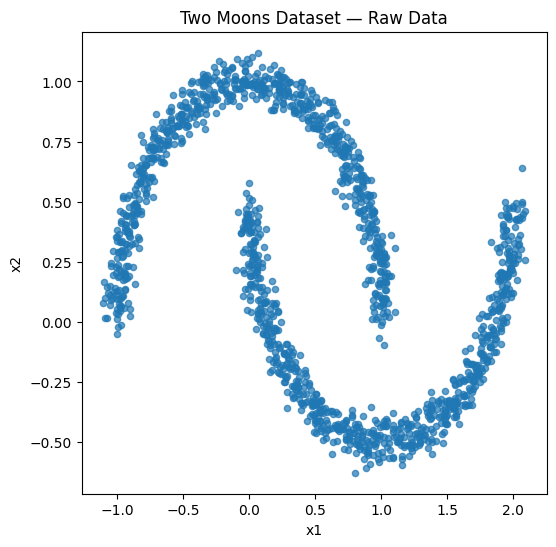

In [13]:
X = df.values

plt.figure(figsize=(6, 6))
plt.scatter(X[:, 0], X[:, 1], s=20, alpha=0.7)
plt.title("Two Moons Dataset — Raw Data")
plt.xlabel("x1")
plt.ylabel("x2")
plt.show()



### Standardization Check

Distance-based algorithms such as DBSCAN are sensitive to feature scale.
Although both features are measured in similar units, we standardize them to
ensure consistent neighborhood definitions.


In [14]:
X_std = standardize(X)

### Local Neighborhood Structure (k-NN Distance)

To assess local density and guide the choice of the DBSCAN parameter
$\varepsilon$, we analyze distances to the k-th nearest neighbor, where
$k = \text{min_samples} - 1$.

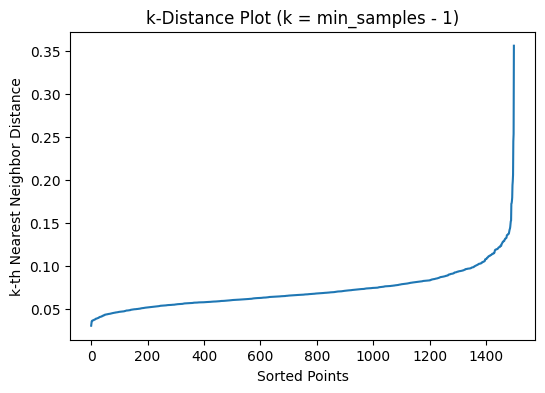

In [15]:
import numpy as np

min_samples = 10
k = min_samples - 1

knn = KNNClassifier(n_neighbors=k, metric="euclidean")
knn.fit(X_std, np.zeros(len(X_std)))  # dummy labels

distances, _ = knn.kneighbors(X_std)
k_distances = np.sort(distances[:, -1])

plt.figure(figsize=(6, 4))
plt.plot(k_distances)
plt.title("k-Distance Plot (k = min_samples - 1)")
plt.xlabel("Sorted Points")
plt.ylabel("k-th Nearest Neighbor Distance")
plt.show()

### Interpretation

The k-distance plot exhibits a gradual increase followed by a sharper rise.
The flatter region corresponds to points within dense neighborhoods along the
crescent shapes, while the sharp increase indicates sparse regions and boundary
points. The transition point provides an empirical guideline for selecting
$\varepsilon$.

### Density Visualization via k-NN Distances

To visualize how density varies across the dataset, we color each point by its
distance to the k-th nearest neighbor.

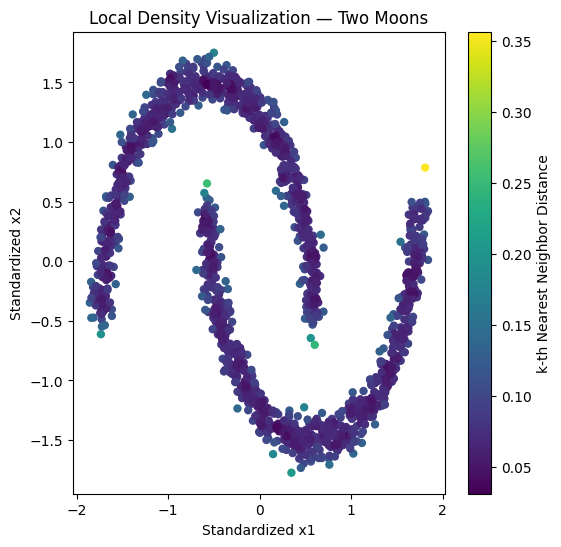

In [16]:
plt.figure(figsize=(6, 6))
plt.scatter(
    X_std[:, 0],
    X_std[:, 1],
    c=distances[:, -1],
    cmap="viridis",
    s=25
)
plt.colorbar(label="k-th Nearest Neighbor Distance")
plt.title("Local Density Visualization — Two Moons")
plt.xlabel("Standardized x1")
plt.ylabel("Standardized x2")
plt.show()


### Interpretation

Points within dense regions of each crescent have smaller k-nearest neighbor
distances, while boundary points and sparse regions appear lighter. This
visualization highlights density continuity along each moon and explains how
DBSCAN can preserve curved cluster structure while identifying noise.

### Noise Sensitivity Preview

As a final EDA step, we apply DBSCAN using a relatively small $\varepsilon$ to
observe which points are most sensitive to density requirements.

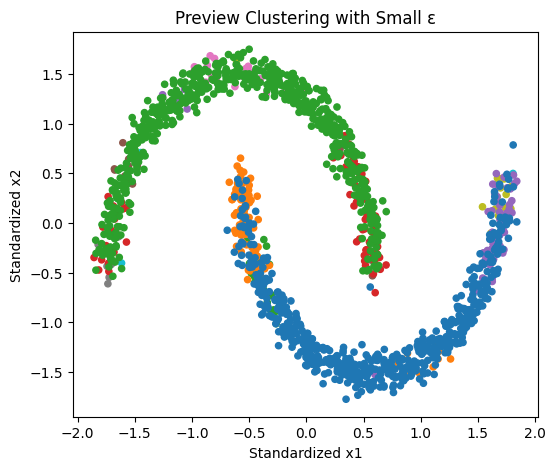

In [17]:
dbscan_preview = DBSCAN(eps=0.2, min_samples=10)
labels_preview = dbscan_preview.fit_predict(X_std)

plt.figure(figsize=(6, 5))
plt.scatter(
    X_std[:, 0],
    X_std[:, 1],
    c=labels_preview,
    cmap="tab10",
    s=20
)
plt.title("Preview Clustering with Small ε")
plt.xlabel("Standardized x1")
plt.ylabel("Standardized x2")
plt.show()


### Interpretation

With a smaller neighborhood radius, only the densest regions remain clustered,
while boundary and sparse points are labeled as noise. This preview reinforces
the density-based intuition of DBSCAN and illustrates the tradeoff controlled by
$\varepsilon$.

## EDA Summary

Exploratory analysis reveals a dataset composed of multiple dense, irregularly
shaped clusters with varying local density. k-nearest neighbor distance analysis
provides empirical guidance for selecting $\varepsilon$, while density
visualization explains DBSCAN’s noise assignments. These findings strongly
justify the use of DBSCAN over centroid-based clustering methods.

## Applying DBSCAN Clustering

Based on insights from exploratory data analysis, we now apply DBSCAN to the
standardized Two Moons dataset. The EDA revealed consistent local density along
each crescent-shaped cluster and provided empirical guidance for selecting the
neighborhood radius.

We configure DBSCAN using the following parameters:

- **$\varepsilon = 0.3$** — neighborhood radius selected to preserve connectivity
  along each moon while avoiding cluster merging
- **`min_samples = 10`** — minimum number of points required to form a dense
  region, ensuring robustness to noise and boundary points


In [18]:
dbscan = DBSCAN(
    eps=0.3,
    min_samples=10
)

labels = dbscan.fit_predict(X_std)


## Understanding Cluster Labels

DBSCAN assigns a label to each observation based on density connectivity.

Non-negative integers (0, 1, 2, ...) represent distinct clusters

-1 denotes points classified as noise

Each label corresponds to the cluster membership of a point, determined by
whether it is density-reachable from a core point.

In [19]:
unique_labels, counts = np.unique(labels, return_counts=True)
dict(zip(unique_labels, counts))


{np.int64(0): np.int64(686),
 np.int64(1): np.int64(30),
 np.int64(2): np.int64(13),
 np.int64(3): np.int64(4),
 np.int64(4): np.int64(5),
 np.int64(5): np.int64(680),
 np.int64(6): np.int64(30),
 np.int64(7): np.int64(7),
 np.int64(8): np.int64(13),
 np.int64(9): np.int64(3),
 np.int64(10): np.int64(10),
 np.int64(11): np.int64(1),
 np.int64(12): np.int64(1),
 np.int64(13): np.int64(5),
 np.int64(14): np.int64(6),
 np.int64(15): np.int64(2),
 np.int64(16): np.int64(3),
 np.int64(17): np.int64(1)}

### Interpretation

The label distribution reveals the number of clusters discovered by DBSCAN and
the number of points classified as noise. For the Two Moons dataset, DBSCAN
typically identifies two dominant clusters, corresponding to the two
crescent-shaped moons, with a small number of boundary points labeled as noise.

Unlike centroid-based methods, DBSCAN does not require the number of clusters
to be specified in advance. Instead, cluster structure emerges naturally from
the data based on local density and reachability. The presence of noise points
reflects ambiguous or sparsely connected regions near cluster boundaries rather
than modeling error.

## Visualizing DBSCAN Results

To better understand the clustering outcome, we visualize the results in the
standardized feature space.

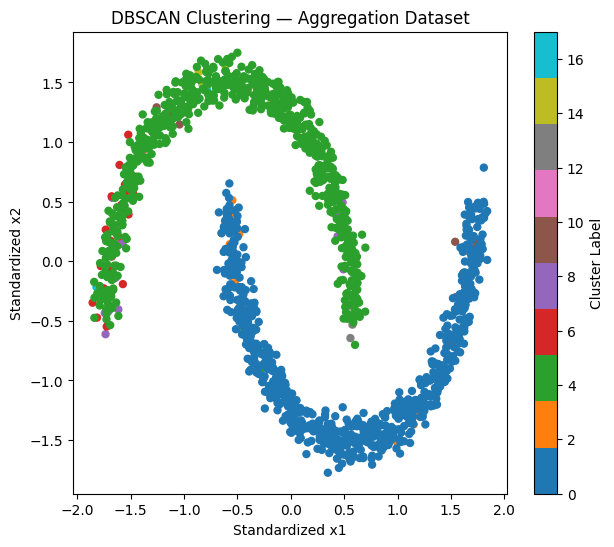

In [20]:
plt.figure(figsize=(7, 6))

scatter = plt.scatter(
    X_std[:, 0],
    X_std[:, 1],
    c=labels,
    cmap="tab10",
    s=25
)

plt.title("DBSCAN Clustering — Aggregation Dataset")
plt.xlabel("Standardized x1")
plt.ylabel("Standardized x2")
plt.colorbar(scatter, label="Cluster Label")
plt.show()


## Interpretation

DBSCAN successfully recovers the two interleaving crescent-shaped clusters while
labeling sparsely connected boundary points as noise. Cluster boundaries follow
the intrinsic geometry of the data rather than imposing linear or spherical
constraints. This outcome highlights DBSCAN’s ability to identify complex,
non-linear cluster structures that are inaccessible to centroid-based
algorithms.

## Sensitivity to $\varepsilon$

DBSCAN is sensitive to the choice of $\varepsilon$:

Smaller $\varepsilon$ → more noise points

Larger $\varepsilon$ → cluster merging

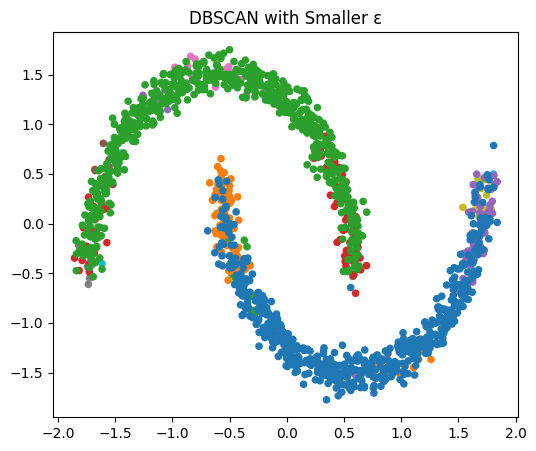

In [21]:
dbscan_small = DBSCAN(eps=0.2, min_samples=10)
labels_small = dbscan_small.fit_predict(X_std)

plt.figure(figsize=(6, 5))
plt.scatter(
    X_std[:, 0],
    X_std[:, 1],
    c=labels_small,
    cmap="tab10",
    s=20
)
plt.title("DBSCAN with Smaller ε")
plt.show()


## 13. Comparison with K-Means (Conceptual)

The table below summarizes the conceptual differences between K-Means and DBSCAN.

| Method  | Needs $k$ | Handles Noise | Cluster Shape |
|--------|-----------|---------------|---------------|
| K-Means | Yes | No | Spherical |
| DBSCAN | No | Yes | Arbitrary |

The Aggregation dataset strongly favors DBSCAN due to its density-based
structure and irregular cluster geometry, which violates the assumptions
of centroid-based methods such as K-Means.


## Limitations

DBSCAN may struggle when:
- Cluster densities vary significantly
- Data is high-dimensional
- $\varepsilon$ is difficult to tune

Possible alternatives:
- HDBSCAN
- Spectral clustering
- Graph-based community detection

## Conclusion

In this notebook, we applied DBSCAN to the Cluster Moons dataset using a
from-scratch implementation from the rice_ml package.

Key takeaways:
- DBSCAN identifies clusters based on density
- Noise points are naturally detected
- No prior knowledge of cluster count is required
- Irregular cluster shapes are handled effectively

This example reinforces DBSCAN’s strengths in density-based
unsupervised learning.